In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision timm scikit-learn matplotlib seaborn --quiet

import os, time, json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00


In [ ]:
BASE_DIR      = '/content/drive/MyDrive/DatasetCombined'
train_dir     = os.path.join(BASE_DIR, 'train')
valid_dir     = os.path.join(BASE_DIR, 'valid')
test_dir      = os.path.join(BASE_DIR, 'test')

num_epochs    = 15
batch_size    = 32
learning_rate = 1e-3
momentum      = 0.9
weight_decay  = 1e-4
patience      = 4   # early stopping & scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
splits = ['train','valid','test']
classes = ['FEMALE','MALE']
print("Image counts:")
for sp in splits:
    print(f"\n{sp.upper()}:")
    for c in classes:
        p = os.path.join(BASE_DIR, sp, c)
        cnt = sum(f.lower().endswith(('.jpg','.png','.jpeg')) for f in os.listdir(p))
        print(f"  {c}: {cnt}")

# Inspect one sample
p0 = os.path.join(test_dir, classes[0])
f0 = [f for f in os.listdir(p0) if f.lower().endswith(('.jpg','.png'))][0]
img = Image.open(os.path.join(p0, f0))
print("\nSample TEST image → Mode:", img.mode, "Size:", img.size)

Image counts:

TRAIN:
  FEMALE: 915
  MALE: 954

VALID:
  FEMALE: 379
  MALE: 393

TEST:
  FEMALE: 54
  MALE: 55

Sample TEST image → Mode: RGB Size: (336, 256)


In [ ]:
data_transforms = {
  'train': transforms.Compose([
     transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(15),
     transforms.ColorJitter(0.2,0.2,0.2),
     transforms.ToTensor(),
     transforms.Normalize([0.5]*3, [0.5]*3)
  ]),
  'valid': transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.5]*3, [0.5]*3)
  ]),
  'test': transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.5]*3, [0.5]*3)
  ]),
}

datasets_dict = {x: datasets.ImageFolder(os.path.join(BASE_DIR, x), data_transforms[x])
                 for x in splits}
print('Classes:', datasets_dict['train'].classes)  # ['FEMALE','MALE']

dataloaders = {x: DataLoader(datasets_dict[x], batch_size=batch_size,
                             shuffle=(x=='train'))
               for x in splits}

Classes: ['FEMALE', 'MALE']


In [ ]:
# Load pretrained EfficientNet-B0
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

# Freeze all MBConv blocks up through block6 (approx first 80% of layers)
for name, param in model.named_parameters():
    if 'blocks.6' not in name and 'classifier' not in name:
        param.requires_grad = False

# Count parameters
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total:,}; Trainable params: {trainable:,}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=learning_rate, momentum=momentum,
                      weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                      mode='min', factor=0.5, patience=patience, verbose=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total params: 4,010,110; Trainable params: 719,794


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
best_val_acc, no_improve = 0.0, 0
train_losses, valid_losses = [], []
train_accs, valid_accs     = [], []

for epoch in range(num_epochs):
    start = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train
    model.train()
    run_loss, run_corr = 0.0, 0
    for imgs, labels in dataloaders['train']:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outs = model(imgs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        preds = outs.argmax(1)
        run_loss += loss.item()*imgs.size(0)
        run_corr += (preds==labels).sum().item()
    tr_loss = run_loss/len(datasets_dict['train'])
    tr_acc  = run_corr/len(datasets_dict['train'])
    train_losses.append(tr_loss); train_accs.append(tr_acc)
    print(f"  Train — loss: {tr_loss:.4f}, acc: {tr_acc:.4f}")

    # Validate
    model.eval()
    v_loss, v_corr = 0.0, 0
    with torch.no_grad():
        for imgs, labels in dataloaders['valid']:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = model(imgs)
            loss = criterion(outs, labels)
            preds = outs.argmax(1)
            v_loss += loss.item()*imgs.size(0)
            v_corr += (preds==labels).sum().item()
    val_loss = v_loss/len(datasets_dict['valid'])
    val_acc  = v_corr/len(datasets_dict['valid'])
    valid_losses.append(val_loss); valid_accs.append(val_acc)
    print(f"  Valid — loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # Scheduler & early stop
    scheduler.step(val_loss)
    if val_acc > best_val_acc:
        best_val_acc, no_improve = val_acc, 0
        torch.save(model.state_dict(), 'best_efficientnet.pth')
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"  Time: {time.time()-start:.1f}s")


Epoch 1/15
  Train — loss: 0.9269, acc: 0.7892
  Valid — loss: 0.6925, acc: 0.7902
  Time: 1068.0s

Epoch 2/15
  Train — loss: 0.3634, acc: 0.8925
  Valid — loss: 0.5625, acc: 0.8420
  Time: 25.9s

Epoch 3/15
  Train — loss: 0.2481, acc: 0.9219
  Valid — loss: 0.5071, acc: 0.8614
  Time: 25.5s

Epoch 4/15
  Train — loss: 0.2218, acc: 0.9283
  Valid — loss: 0.5424, acc: 0.8484
  Time: 25.7s

Epoch 5/15
  Train — loss: 0.1535, acc: 0.9508
  Valid — loss: 0.5154, acc: 0.8601
  Time: 25.5s

Epoch 6/15
  Train — loss: 0.1301, acc: 0.9567
  Valid — loss: 0.5657, acc: 0.8484
  Time: 25.6s

Epoch 7/15
  Train — loss: 0.1109, acc: 0.9599
  Valid — loss: 0.5440, acc: 0.8549
Early stopping at epoch 7


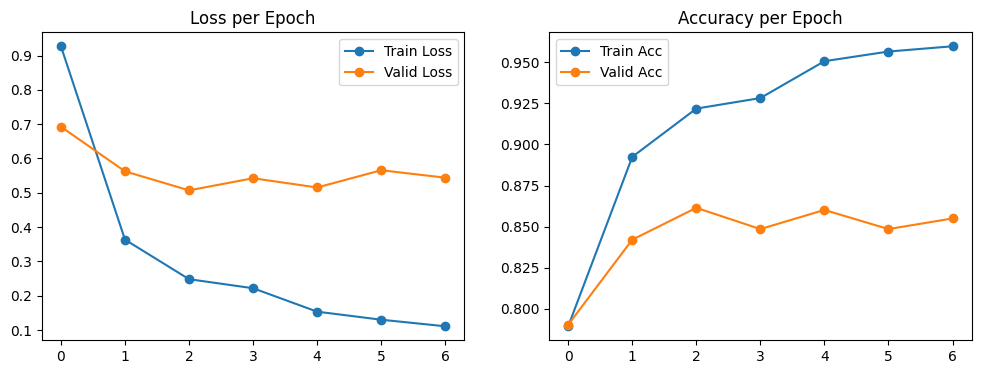

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses,'-o',label='Train Loss')
plt.plot(valid_losses,'-o',label='Valid Loss')
plt.title('Loss per Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs,'-o',label='Train Acc')
plt.plot(valid_accs,'-o',label='Valid Acc')
plt.title('Accuracy per Epoch'); plt.legend()
plt.show()

Confusion Matrix:
 [[45  9]
 [10 45]]

Classification Report:
               precision    recall  f1-score   support

      FEMALE       0.82      0.83      0.83        54
        MALE       0.83      0.82      0.83        55

    accuracy                           0.83       109
   macro avg       0.83      0.83      0.83       109
weighted avg       0.83      0.83      0.83       109



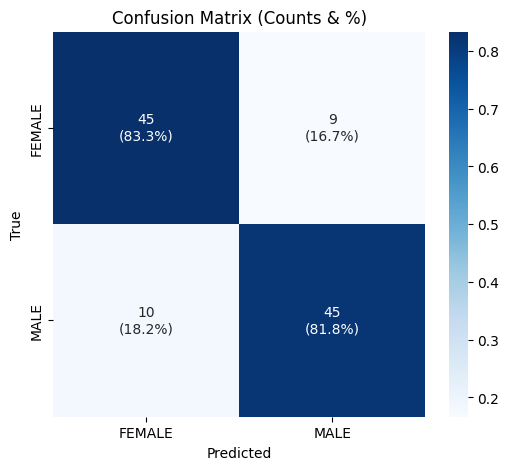

In [ ]:
model.load_state_dict(torch.load('best_efficientnet.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in dataloaders['test']:
        imgs = imgs.to(device)
        out  = model(imgs)
        preds= out.argmax(1).cpu().tolist()
        all_preds += preds; all_labels += labels.tolist()

cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:\n', cm)
print('\nClassification Report:\n',
      classification_report(all_labels, all_preds, target_names=classes))

# Percentage CM
cm_norm = cm.astype(float)/cm.sum(axis=1)[:,None]
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i,j] = f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)"
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=annot, fmt='', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix (Counts & %)')
plt.show()

In [ ]:
# Save Artifacts to Google Drive

from google.colab import drive
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# a) Save best model weights
torch.save(model.state_dict(), '/content/drive/MyDrive/best_efficientnet.pth')

# b) Save training history (losses & accuracies)
history = {
    'train_loss': train_losses,
    'valid_loss': valid_losses,
    'train_acc': train_accs,
    'valid_acc': valid_accs
}
with open('/content/drive/MyDrive/efficientnet_history.json', 'w') as f:
    json.dump(history, f)

# c) Save loss & accuracy plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, '-o', label='Train Loss')
plt.plot(valid_losses, '-o', label='Valid Loss')
plt.title('Loss per Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, '-o', label='Train Acc')
plt.plot(valid_accs, '-o', label='Valid Acc')
plt.title('Accuracy per Epoch'); plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/efficientnet_training_curves.png')
plt.close()

# d) Save raw confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Counts)')
plt.savefig('/content/drive/MyDrive/efficientnet_confusion_matrix.png')
plt.close()

# e) Save percentage confusion matrix heatmap
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i,j] = f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)"

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=annot, fmt='', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Counts & %)')
plt.savefig('/content/drive/MyDrive/efficientnet_confusion_matrix_pct.png')
plt.close()

# f) Save classification report as JSON
report = classification_report(all_labels, all_preds,
                               target_names=classes,
                               output_dict=True)
with open('/content/drive/MyDrive/efficientnet_classification_report.json', 'w') as f:
    json.dump(report, f, indent=4)

print("✅ All EfficientNet artifacts saved to Google Drive under MyDrive/")


✅ All EfficientNet artifacts saved to Google Drive under MyDrive/
